In [1]:
%load_ext autoreload
%autoreload 2

# qd_lasing_dynamics package Tutorial

This package is for analyzing quantum dot lasing dynamics in a Baysian framework.  It has objects for defining priors, the model, and doing Baysian parameter estimation with emcee.  

## Model Definition

Our theoretical model is the solution set to a set of three rate equations (see below). In this model, as is described in [1], it is assumed that carriers are injected into a quantum dot laser via a quantum well and then are subsequently captured by quantum dots for radiative recombination. These coupled rate equations relate Photon Density, Quantum Dot occupation probability, and Carrier Density in the quantum well:

$$
\dot{S} = -\frac{S}{\tau_s} + g_0v(2\rho-1)S \tag{1}
$$

$$
\dot{\rho} = -\frac{\rho}{\tau_d} - g_0(2\rho-1)S + F(N,\rho) \tag{2}
$$

$$
\dot{N} = J - \frac{N}{\tau_n} - 2N_dF(N,\rho) \tag{3}
$$

Where S is photon density; N is carrier density in the quantum well; $\rho$ is the occupation probability in a quantum dot; $\tau_s$ is the photon lifetime; $\tau_n$ and $\tau_d$ are the carrier lifetimes in the well and the dot, respectively; $N_d$ is the 2D density of Quantum Dots, and J is the pump current density. $g_0 = \sigma_{res}v_g$, where $\sigma_{res}$ is the cross section of interaction of carriers in the dots with photons; $v_g$ is the group velocity; and $v = 2N_d\Gamma/d$, where $\Gamma$ is the confinement factor and $d$ is the thickness of the dot layer.

Additionally,

$$
F(N,\rho) = R_{cap}(1-\rho)-R_{esc}\rho \tag{4}
$$

Where $R_{cap} = CN^2 + BN$. C describes Auger carrier capture while B describes carrier-phonon capture. $R_{esc}$ is the rate of escape of carriers from quantum dots and is a temperature dependent function. 

By solving equations 1-3 in steady state, we can define S, $\rho$, and N in terms of input current, or J. Therefore, the S function in terms of J is essentially your "lasing curve". This curve will be what we are "fitting" our data to, as this is the format our data is in. 

When taking lasing curves on our devices, there is a gaussian distribution of noise with standard deviation X units, which will be our likelihood. This noise is generated from a variety of experimental parameters, including stage drift, different spatial excitations of the cavities, and variations in gain media composition across samples. Additionally, we will be assuming a flat prior for our C coefficient, or the Auger capture rate. Therefore, our statistical model will be:

$$
y_i = Normal(\mu, \sigma)
$$

$$
\mu = Steady\hspace{1mm}state\hspace{1mm}solution\hspace{1mm}of\hspace{1mm}photon\hspace{1mm}number\hspace{1mm}to\hspace{1mm}equations\hspace{1mm}1-3
$$

$$
C \simeq Uniform(10^{-21}, 10^{-19})m^4/s
$$

So our likelihood function will be:

$$
\mathcal{L} = \prod_{i}^{N} \frac{1}{\sqrt{2\pi\sigma_{yi}^2}}\exp\left({\frac{\left[-y_i - \mu_i(x_i)\right]^2}{2\sigma_{yi}^2}}\right)
$$

where $\mu_i(x_i)$ is the photon number (or "S") solution of the steady state rate equations at various input current densities, $x_i$. From this model, we can infer 1 parameter, the C coefficient, for our minimal proof-of-concept goal. Future iterations of this will involve inference of more parameters.

Additionally, for this initial proof-of-concept, we will only be focusing in the regime after lasing threshold is reached. This is because the solutions to the rate equations are stable in this regime. Additionally, an analysis in this regime is more appropriate from a physical perspective, as light emission is dominated by quantum dots above threshold (and this model only assumes one radiatively emitting gain material). 

## Demonstration of model

### Standard Imports

In [1]:
from numpy import exp
import emcee
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import fsolve
from qddynamics.inference.model import JefferysPrior, UniformPrior, LogLikelihood
from data_files.io import get_example_data_file_path, load_data

Matplotlib is building the font cache; this may take a moment.


### Example of likelihood and posterior calculation using a Uniform Prior

Here we upload our simulation data. This data follows directly from the solution to equations 1-3 in steady state, using O'Brien's values for all of the constants/parameters. Therefore, when we perform inference on the data, the C value should be 10E-20 $\frac{m^4}{s}$, which is exactly what O'Brien et. al. assume in their paper. Note this is the same format our experimental data will be in, as we collect light output intensity at various input powers only at our lasing wavelength (which is extracted from PL spectra). 

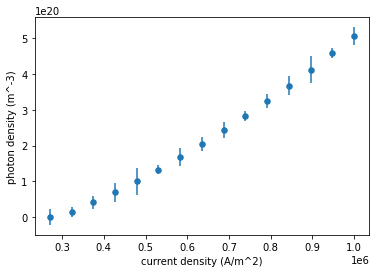

In [2]:
import pandas as pd

simulated_data_frame = load_data(get_example_data_file_path('simulated_data_csv.csv'))

x = simulated_data_frame['x'][:]
y = simulated_data_frame['y'][:]
sigma_y = simulated_data_frame['sigma_y'][:]
simulated_data_frame.columns = ['current density (A/m^2)', 'photon density (m^-3)', 'sigma_y']

## plot the test data
simulated_data_frame.plot(x='current density (A/m^2)', y='photon density (m^-3)', kind='scatter', yerr='sigma_y', s=30)

## User must specify the initial guess for the constant
initial_guess = np.array([1E18,0.5,1E15])

## define posterior equation, which adds
## the result of our log prior and log likelihood functions

def log_posterior(theta, x, y, sigma_y):
    return UniformPrior(10e-21, 10e-19).logp(10e-20) + LogLikelihood(theta, x, y, sigma_y, initial_guess).logllh()

In [4]:
# the model has 1 parameters; we'll use 50 walkers and 500 steps each
ndim = 1
nwalkers = 50
nsteps = 500

# Here's an initial guess slightly off from the paper's parameter value
# to show how the MCMC equilibrates to the correct value
ls_result = [0.8e-20] 
gaussian_ball = 1e-4 * np.random.randn(nwalkers, ndim)
starting_positions = (1 + gaussian_ball) * ls_result

In [5]:
# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=(x, y, sigma_y))
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


Wall time: 4min 24s
Done


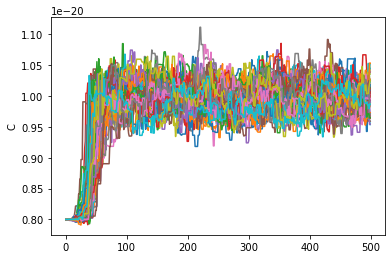

In [6]:
fig, (ax_C) = plt.subplots(1)
ax_C.set(ylabel='C')
for i in range(50):
    # to use seaborn's lineplot, we first need to make a dataframe
    df = pd.DataFrame({'C': sampler.chain[i,:,0]})
    sns.lineplot(data=df, x=df.index, y='C', ax=ax_C)

In [7]:
samples = sampler.chain[:,100:,:]
# reshape the samples into a 1D array where the colums are m and b
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels.  This will come in handy 
# in a moment, when we start using seaborn to plot our results 
# (among other things, it saves us the trouble of typing in labels
# for our plots)
parameter_samples = pd.DataFrame({'C': traces[0]})

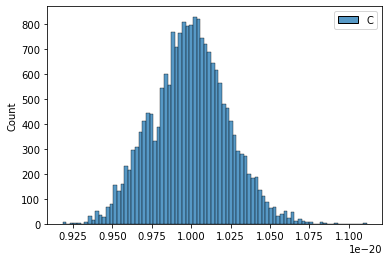

In [8]:
joint_kde = sns.histplot(data=parameter_samples)

## Report Results

In [9]:
# calculating the MAP and values can be done concisely using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)
print("C = {:.2e} + {:.2e} - {:.2e}".format(q['C'][0.50], 
                                            q['C'][0.84]-q['C'][0.50],
                                            q['C'][0.50]-q['C'][0.16]))

C = 1.00e-20 + 2.31e-22 - 2.52e-22


### References
1. O’Brien, D., Hegarty, S.P., Huyet, G. and Uskov, A.V., 2004. Sensitivity of quantum-dot semiconductor lasers to optical feedback. Optics letters, 29(10), pp.1072-1074.